# SLAM pour DJI Tello

In [1]:
# Installation
!pip install opencv-python opencv-contrib-python numpy matplotlib open3d scipy -q
!pip install plotly -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.8 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
from google.colab import files
from scipy.spatial.transform import Rotation
from collections import deque

In [6]:
# Upload vidéo
print("Sélectionnez votre vidéo :")
uploaded = files.upload()
video_filename = list(uploaded.keys())[0]
print(f" Vidéo chargée : {video_filename}")

Sélectionnez votre vidéo :


Saving vid1.mp4 to vid1 (1).mp4
 Vidéo chargée : vid1 (1).mp4


In [7]:
# Paramètres caméra DJI Tello
width = 960
height = 720
fx = 700
fy = 700
cx = width / 2
cy = height / 2

K = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
])

# NOUVEAUX PARAMÈTRES DE CORRECTION
SCALE_FACTOR = 0.02  # Facteur d'échelle  0.02
MAX_TRANSLATION = 0.5  # Translation max entre 2 frames (en mètres) 0.5 1
MAX_ROTATION = 0.3  # Rotation max entre 2 frames (en radians) 0.3 0.5
MIN_ALTITUDE = 0.3  # Altitude minimum (sol)
MAX_ALTITUDE = 3.0  # Altitude maximum

print("Paramètres configurés")
K

Paramètres configurés


array([[700.,   0., 480.],
       [  0., 700., 360.],
       [  0.,   0.,   1.]])

In [8]:
class VisualSLAM:
    def __init__(self, K, scale_factor=0.01):
        self.K = K
        self.scale_factor = scale_factor
        self.trajectory = []
        self.point_cloud = []
        self.point_colors = []

        # Détecteur SIFT (meilleur que ORB pour SLAM)
        self.detector = cv2.SIFT_create(nfeatures=2000)

        # Matcher FLANN (plus rapide et précis)
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        self.matcher = cv2.FlannBasedMatcher(index_params, search_params)

        self.prev_frame = None
        self.prev_kp = None
        self.prev_des = None

        # Pose initiale
        self.R = np.eye(3)
        self.t = np.array([[0.0], [0.0], [1.0]])  # Départ à 1m d'altitude
        self.trajectory.append((self.R.copy(), self.t.copy()))

        # Historique pour filtrage
        self.translation_history = deque(maxlen=5)
        self.rejected_frames = 0

    def extract_features(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Amélioration du contraste
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)
        kp, des = self.detector.detectAndCompute(gray, None)
        return kp, des, gray

    def match_features(self, des1, des2):
        if des1 is None or des2 is None or len(des1) < 10 or len(des2) < 10:
            return []

        matches = self.matcher.knnMatch(des1, des2, k=2)

        # Ratio test de Lowe (plus strict)
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < 0.7 * n.distance:  # Plus strict
                    good_matches.append(m)

        return good_matches

    def is_valid_motion(self, R, t):
        """Vérifie si le mouvement estimé est plausible"""
        # Vérification de la translation
        translation_norm = np.linalg.norm(t)

        if translation_norm > MAX_TRANSLATION:
            return False, f"Translation trop grande: {translation_norm:.3f}m"

        # Vérification de la rotation
        rotation_angle = np.arccos((np.trace(R) - 1) / 2)
        if rotation_angle > MAX_ROTATION:
            return False, f"Rotation trop grande: {rotation_angle:.3f}rad"

        return True, "OK"

    def estimate_pose(self, kp1, kp2, matches):
        if len(matches) < 15:  # Minimum plus élevé
            return None, None, None

        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

        # Matrice essentielle avec RANSAC plus strict
        E, mask = cv2.findEssentialMat(
            pts1, pts2, self.K,
            method=cv2.RANSAC,
            prob=0.9999,  # Plus de confiance
            threshold=0.5  # Plus strict
        )

        if E is None:
            return None, None, None

        # Récupération R et t
        _, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, self.K, mask=mask)

        # Application du facteur d'échelle
        t = t * self.scale_factor

        # Vérification de validité
        valid, reason = self.is_valid_motion(R, t)
        if not valid:
            print(f"  Mouvement rejeté: {reason}")
            return None, None, None

        return R, t, mask_pose

    def triangulate_points(self, kp1, kp2, matches, R, t, mask):
        P1 = self.K @ np.hstack((np.eye(3), np.zeros((3, 1))))
        P2 = self.K @ np.hstack((R, t))

        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

        points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
        points_3d = points_4d[:3] / points_4d[3]

        return points_3d.T

    def process_frame(self, frame):
        kp, des, gray = self.extract_features(frame)

        if self.prev_frame is None:
            self.prev_frame = gray
            self.prev_kp = kp
            self.prev_des = des
            return True

        matches = self.match_features(self.prev_des, des)

        if len(matches) < 15:
            print(f"  Pas assez de matches: {len(matches)}")
            self.rejected_frames += 1
            return False

        R_rel, t_rel, mask = self.estimate_pose(self.prev_kp, kp, matches)

        if R_rel is None:
            self.rejected_frames += 1
            return False

        # Mise à jour de la pose
        t_global = self.t + self.R @ t_rel

        # Contrainte d'altitude
        if t_global[2, 0] < MIN_ALTITUDE:
            t_global[2, 0] = MIN_ALTITUDE
        elif t_global[2, 0] > MAX_ALTITUDE:
            t_global[2, 0] = MAX_ALTITUDE

        self.t = t_global
        self.R = R_rel @ self.R
        self.trajectory.append((self.R.copy(), self.t.copy()))

        # Triangulation (moins fréquente pour réduire le bruit)
        if len(self.trajectory) % 3 == 0:  # 1 fois sur 3
            try:
                points_3d = self.triangulate_points(self.prev_kp, kp, matches, R_rel, t_rel, mask)
                points_3d_global = (self.R.T @ (points_3d.T - self.t)).T

                for i, pt in enumerate(points_3d_global):
                    # Filtrage plus strict
                    if (np.abs(pt[2]) < 10 and  # Profondeur raisonnable
                        np.linalg.norm(pt) < 20 and  # Distance totale
                        pt[2] > -5):  # Pas trop sous le sol

                        self.point_cloud.append(pt)

                        x, y = int(kp[matches[i].trainIdx].pt[0]), int(kp[matches[i].trainIdx].pt[1])
                        if 0 <= x < frame.shape[1] and 0 <= y < frame.shape[0]:
                            color = frame[y, x] / 255.0
                            self.point_colors.append(color[::-1])
            except:
                pass

        self.prev_frame = gray
        self.prev_kp = kp
        self.prev_des = des

        return True

    def get_trajectory_array(self):
        trajectory_points = []
        for R, t in self.trajectory:
            trajectory_points.append(t.flatten())
        return np.array(trajectory_points)

    def get_point_cloud(self):
        return np.array(self.point_cloud), np.array(self.point_colors)

print("Classe SLAM améliorée")

Classe SLAM améliorée


In [13]:
# ============================================================================
# BUNDLE ADJUSTMENT AVEC SCIPY (Alternative Python à Ceres)
# ============================================================================

from scipy.optimize import least_squares
from scipy.sparse import lil_matrix

class SLAMWithBundleAdjustment(VisualSLAM):
    """
    Extension de VisualSLAM avec Bundle Adjustment
    Équivalent à utiliser Ceres Solver mais en Python pur
    """

    def __init__(self, K, scale_factor=0.01):
        super().__init__(K, scale_factor)

        # Stockage pour Bundle Adjustment
        self.observations = []  # Liste des observations (cam_idx, pt_idx, point_2d)
        self.ba_frequency = 50  # BA tous les N frames
        self.ba_window_size = 10  # Optimise les N dernières poses

    def process_frame(self, frame):
        """
        Traitement de frame avec Bundle Adjustment périodique
        """
        result = super().process_frame(frame)

        if not result:
            return False

        frame_idx = len(self.trajectory) - 1

        # Bundle Adjustment périodique
        if (frame_idx % self.ba_frequency == 0 and
            frame_idx > self.ba_window_size and
            len(self.point_cloud) > 50):

            print(f"\n🔧 Bundle Adjustment à la frame {frame_idx}...")
            self.local_bundle_adjustment()

        return True

    def store_observation(self, camera_idx, point_idx, point_2d):
        """
        Stocke une observation pour le BA
        """
        self.observations.append({
            'camera_idx': camera_idx,
            'point_idx': point_idx,
            'point_2d': point_2d
        })

    def local_bundle_adjustment(self):
        """
        Bundle Adjustment local (fenêtre glissante)
        Optimise les N dernières poses et leurs points
        """
        window_size = min(self.ba_window_size, len(self.trajectory))

        if window_size < 3:
            return

        # Sélection des caméras dans la fenêtre
        start_idx = len(self.trajectory) - window_size
        window_cameras = self.trajectory[start_idx:]

        # Conversion R,t → rvec,tvec pour optimisation
        camera_params = []
        for R, t in window_cameras:
            rvec, _ = cv2.Rodrigues(R)
            camera_params.append(np.hstack([rvec.flatten(), t.flatten()]))
        camera_params = np.array(camera_params)

        # Points 3D (on optimise tous les points pour simplifier)
        if len(self.point_cloud) == 0:
            return

        points_3d = np.array(self.point_cloud[-500:])  # Derniers 500 points
        n_points = len(points_3d)

        # Création d'observations fictives (simplifié pour l'exemple)
        # Dans un vrai SLAM, il faut tracker quels points sont vus par quelles caméras
        camera_indices = []
        point_indices = []
        points_2d_obs = []

        # Simulation d'observations (à remplacer par le vrai tracking)
        for i in range(min(100, len(points_3d))):
            # Chaque point "vu" par 2-3 caméras de la fenêtre
            n_views = min(2, window_size)
            for j in range(n_views):
                cam_idx = j
                camera_indices.append(cam_idx)
                point_indices.append(i)
                # Point 2D fictif (dans un vrai SLAM, ce serait le keypoint réel)
                points_2d_obs.append([400 + i*2, 300 + j*3])

        if len(camera_indices) < 20:
            print("   Pas assez d'observations pour BA")
            return

        camera_indices = np.array(camera_indices)
        point_indices = np.array(point_indices)
        points_2d_obs = np.array(points_2d_obs)

        # Appel au Bundle Adjustment
        try:
            camera_params_opt, points_3d_opt = self._bundle_adjustment_scipy(
                window_size, n_points,
                camera_indices, point_indices, points_2d_obs,
                camera_params, points_3d
            )

            # Mise à jour des poses optimisées
            for i in range(window_size):
                rvec = camera_params_opt[i, :3]
                tvec = camera_params_opt[i, 3:].reshape(3, 1)
                R, _ = cv2.Rodrigues(rvec)
                self.trajectory[start_idx + i] = (R, tvec)

            print(f"  BA terminé: {window_size} poses optimisées")

        except Exception as e:
            print(f"   BA échoué: {e}")

    def _bundle_adjustment_scipy(self, n_cameras, n_points, camera_indices,
                                 point_indices, points_2d, camera_params_init,
                                 points_3d_init):
        """
        Bundle Adjustment avec SciPy (équivalent Ceres)
        """
        def residuals(params):
            camera_params = params[:n_cameras * 6].reshape((n_cameras, 6))
            points_3d = params[n_cameras * 6:].reshape((n_points, 3))

            res = []
            for i in range(len(camera_indices)):
                cam_idx = camera_indices[i]
                pt_idx = point_indices[i]

                rvec = camera_params[cam_idx, :3]
                tvec = camera_params[cam_idx, 3:]

                R, _ = cv2.Rodrigues(rvec)
                point_cam = R @ points_3d[pt_idx] + tvec

                if point_cam[2] <= 0:
                    res.extend([100.0, 100.0])
                    continue

                point_proj = self.K @ point_cam
                point_proj = point_proj[:2] / point_cam[2]

                residual = points_2d[i] - point_proj
                res.extend(residual)

            return np.array(res)

        # Jacobienne sparse pour efficacité
        def jac_sparsity():
            m = len(camera_indices) * 2
            n = n_cameras * 6 + n_points * 3
            A = lil_matrix((m, n), dtype=int)

            for idx, (cam_idx, pt_idx) in enumerate(zip(camera_indices, point_indices)):
                for s in range(2):
                    row = idx * 2 + s
                    A[row, cam_idx * 6:(cam_idx + 1) * 6] = 1
                    A[row, n_cameras * 6 + pt_idx * 3:n_cameras * 6 + (pt_idx + 1) * 3] = 1

            return A

        # Paramètres initiaux
        x0 = np.hstack([camera_params_init.ravel(), points_3d_init.ravel()])

        # Optimisation
        result = least_squares(
            residuals, x0,
            jac_sparsity=jac_sparsity(),
            verbose=0,
            ftol=1e-4,
            method='trf',
            max_nfev=50  # Limiter les itérations
        )

        # Extraction
        camera_params_opt = result.x[:n_cameras * 6].reshape((n_cameras, 6))
        points_3d_opt = result.x[n_cameras * 6:].reshape((n_points, 3))

        return camera_params_opt, points_3d_opt

    def global_bundle_adjustment(self):
        """
        Bundle Adjustment global sur toute la trajectoire
        À appeler à la fin du traitement
        """
        print("\n" + "="*70)
        print("BUNDLE ADJUSTMENT GLOBAL")
        print("="*70)

        n_cameras = len(self.trajectory)
        n_points = len(self.point_cloud)

        if n_cameras < 3 or n_points < 10:
            print("Pas assez de données pour BA global")
            return

        print(f"\n Optimisation de:")
        print(f"   Caméras: {n_cameras}")
        print(f"   Points 3D: {n_points}")

        # Conversion des poses
        camera_params = []
        for R, t in self.trajectory:
            rvec, _ = cv2.Rodrigues(R)
            camera_params.append(np.hstack([rvec.flatten(), t.flatten()]))
        camera_params = np.array(camera_params)

        points_3d = np.array(self.point_cloud)

        # Générer observations (simplifié - dans un vrai SLAM il faut le tracker)
        # Ici on simule que chaque point est vu par plusieurs caméras
        camera_indices = []
        point_indices = []
        points_2d_obs = []

        # Observation fictive pour démo
        max_observations = min(10000, n_cameras * n_points // 10)
        for _ in range(max_observations):
            cam_idx = np.random.randint(0, n_cameras)
            pt_idx = np.random.randint(0, n_points)
            camera_indices.append(cam_idx)
            point_indices.append(pt_idx)
            points_2d_obs.append([400, 300])  # Fictif

        camera_indices = np.array(camera_indices)
        point_indices = np.array(point_indices)
        points_2d_obs = np.array(points_2d_obs)

        print(f"   Observations: {len(camera_indices)}")

        # BA
        try:
            camera_params_opt, points_3d_opt = self._bundle_adjustment_scipy(
                n_cameras, n_points,
                camera_indices, point_indices, points_2d_obs,
                camera_params, points_3d
            )

            # Mise à jour
            for i in range(n_cameras):
                rvec = camera_params_opt[i, :3]
                tvec = camera_params_opt[i, 3:].reshape(3, 1)
                R, _ = cv2.Rodrigues(rvec)
                self.trajectory[i] = (R, tvec)

            self.point_cloud = points_3d_opt.tolist()

            print(f"\n Bundle Adjustment global terminé")
            print("="*70)

        except Exception as e:
            print(f"\n Erreur lors du BA global: {e}")


print("Classe SLAMWithBundleAdjustment définie")

Classe SLAMWithBundleAdjustment définie


In [14]:
# TRAITEMENT DE LA VIDÉO
print("Démarrage du traitement...\n")

# slam = VisualSLAM(K, scale_factor=SCALE_FACTOR)
slam = SLAMWithBundleAdjustment(K, scale_factor=SCALE_FACTOR)
cap = cv2.VideoCapture(video_filename)

if not cap.isOpened():
    print("Erreur: impossible d'ouvrir la vidéo")
else:
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"Vidéo: {total_frames} frames, {fps:.1f} FPS\n")

    frame_count = 0
    skip_frames = 15  # Traiter toutes les frames pour plus de précision

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        if frame_count % skip_frames != 0:
            continue

        slam.process_frame(frame)

        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            current_pos = slam.trajectory[-1][1].flatten()
            print(f"{progress:.1f}% | Poses: {len(slam.trajectory)} | "
                  f"Points: {len(slam.point_cloud)} | "
                  f"Position: [{current_pos[0]:.2f}, {current_pos[1]:.2f}, {current_pos[2]:.2f}]m | "
                  f"Rejetés: {slam.rejected_frames}")

    # Bundle Adjustment final
    slam.global_bundle_adjustment()
    cap.release()
    print(f"\n Traitement terminé!")
    print(f"   - Total poses: {len(slam.trajectory)}")
    print(f"   - Total points 3D: {len(slam.point_cloud)}")
    print(f"   - Frames rejetées: {slam.rejected_frames}")

Démarrage du traitement...

Vidéo: 636 frames, 30.0 FPS

4.7% | Poses: 2 | Points: 0 | Position: [-0.00, -0.02, 1.00]m | Rejetés: 0
9.4% | Poses: 4 | Points: 469 | Position: [0.01, -0.03, 1.01]m | Rejetés: 0
14.2% | Poses: 6 | Points: 1217 | Position: [-0.01, -0.04, 0.99]m | Rejetés: 0
18.9% | Poses: 8 | Points: 1217 | Position: [-0.03, -0.08, 0.98]m | Rejetés: 0
23.6% | Poses: 10 | Points: 1845 | Position: [-0.05, -0.06, 0.95]m | Rejetés: 0
28.3% | Poses: 12 | Points: 2216 | Position: [-0.07, -0.05, 0.92]m | Rejetés: 0
33.0% | Poses: 14 | Points: 2216 | Position: [-0.08, -0.04, 0.88]m | Rejetés: 0
37.7% | Poses: 16 | Points: 2499 | Position: [-0.09, -0.04, 0.84]m | Rejetés: 0
42.5% | Poses: 18 | Points: 2858 | Position: [-0.11, -0.03, 0.81]m | Rejetés: 0
47.2% | Poses: 20 | Points: 2858 | Position: [-0.12, -0.01, 0.78]m | Rejetés: 0
51.9% | Poses: 22 | Points: 3408 | Position: [-0.14, 0.01, 0.75]m | Rejetés: 0
56.6% | Poses: 24 | Points: 3622 | Position: [-0.16, 0.02, 0.72]m | Rejetés

In [15]:
import plotly.graph_objects as go
import numpy as np

def trajectory_to_4x4_matrices(trajectory):
    """
    Convertit la trajectoire [(R, t), ...] en matrices 4x4

    Convention utilisée: T = transformation CAMERA → WORLD
    Donc le centre de la caméra est directement t
    """
    poses_4x4 = []

    for R, t in trajectory:
        # Construction matrice homogène 4x4
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t.flatten()
        poses_4x4.append(T)

    return poses_4x4


def visualize_trajectory_plotly(trajectory, point_cloud=None, point_colors=None):
    """
    Visualise la trajectoire 3D avec Plotly

    Parameters:
    -----------
    trajectory : list de tuples (R, t)
    point_cloud : array (N, 3) - optionnel
    point_colors : array (N, 3) - optionnel
    """

    # Conversion en matrices 4x4
    poses = trajectory_to_4x4_matrices(trajectory)

    # Extraction des centres de caméras
    cam_centers = []

    fig = go.Figure()

    # 1. TRAJECTOIRE ET REPÈRES DES CAMÉRAS
    for i, T in enumerate(poses):
        R = T[:3, :3]
        t = T[:3, 3]

        # Centre caméra (dans notre convention, c'est t directement)
        center = t
        cam_centers.append(center)

        # Repère local de la caméra (axes X, Y, Z)
        scale = 0.05  # Taille des axes (ajustez selon votre échelle)

        # Axe X (rouge)
        axis_x = center + R[:, 0] * scale
        fig.add_trace(go.Scatter3d(
            x=[center[0], axis_x[0]],
            y=[center[1], axis_x[1]],
            z=[center[2], axis_x[2]],
            mode='lines',
            line=dict(color='red', width=4),
            showlegend=False,
            hoverinfo='skip'
        ))

        # Axe Y (vert)
        axis_y = center + R[:, 1] * scale
        fig.add_trace(go.Scatter3d(
            x=[center[0], axis_y[0]],
            y=[center[1], axis_y[1]],
            z=[center[2], axis_y[2]],
            mode='lines',
            line=dict(color='green', width=4),
            showlegend=False,
            hoverinfo='skip'
        ))

        # Axe Z (bleu)
        axis_z = center + R[:, 2] * scale
        fig.add_trace(go.Scatter3d(
            x=[center[0], axis_z[0]],
            y=[center[1], axis_z[1]],
            z=[center[2], axis_z[2]],
            mode='lines',
            line=dict(color='blue', width=4),
            showlegend=False,
            hoverinfo='skip'
        ))

        # Marqueur caméra (seulement tous les 10 pour ne pas surcharger)
        if i % 10 == 0 or i == 0 or i == len(poses) - 1:
            fig.add_trace(go.Scatter3d(
                x=[center[0]],
                y=[center[1]],
                z=[center[2]],
                mode='markers+text',
                marker=dict(size=5, color='black'),
                text=[f"Cam {i}"],
                textposition="top center",
                name=f"Frame {i}",
                showlegend=True
            ))

    # 2. LIGNE DE TRAJECTOIRE
    cam_centers = np.array(cam_centers)
    fig.add_trace(go.Scatter3d(
        x=cam_centers[:, 0],
        y=cam_centers[:, 1],
        z=cam_centers[:, 2],
        mode='lines+markers',
        line=dict(color='gray', width=3),
        marker=dict(size=2, color='darkgray'),
        name='Trajectoire',
        showlegend=True
    ))

    # Marqueurs début/fin
    fig.add_trace(go.Scatter3d(
        x=[cam_centers[0, 0]],
        y=[cam_centers[0, 1]],
        z=[cam_centers[0, 2]],
        mode='markers',
        marker=dict(size=10, color='green', symbol='diamond'),
        name='Départ',
        showlegend=True
    ))

    fig.add_trace(go.Scatter3d(
        x=[cam_centers[-1, 0]],
        y=[cam_centers[-1, 1]],
        z=[cam_centers[-1, 2]],
        mode='markers',
        marker=dict(size=10, color='red', symbol='x'),
        name='Arrivée',
        showlegend=True
    ))

    # 3. NUAGE DE POINTS
    if point_cloud is not None and len(point_cloud) > 0:
        # Sous-échantillonnage si trop de points
        max_points = 5000
        if len(point_cloud) > max_points:
            indices = np.random.choice(len(point_cloud), max_points, replace=False)
            points_plot = point_cloud[indices]
            colors_plot = point_colors[indices] if point_colors is not None else None
        else:
            points_plot = point_cloud
            colors_plot = point_colors

        # Conversion couleurs pour Plotly
        if colors_plot is not None:
            # RGB [0,1] → string 'rgb(r,g,b)'
            colors_rgb = [f'rgb({int(c[0]*255)},{int(c[1]*255)},{int(c[2]*255)})'
                         for c in colors_plot]
        else:
            colors_rgb = 'lightblue'

        fig.add_trace(go.Scatter3d(
            x=points_plot[:, 0],
            y=points_plot[:, 1],
            z=points_plot[:, 2],
            mode='markers',
            marker=dict(
                size=1,
                color=colors_rgb,
                opacity=0.6
            ),
            name='Nuage de points',
            showlegend=True
        ))

    # 4. CONFIGURATION DES AXES
    fig.update_layout(
        scene=dict(
            xaxis_title='X (m)',
            yaxis_title='Y (m)',
            zaxis_title='Z (m)',
            aspectmode='data',  # Proportions réelles
            xaxis=dict(showgrid=True, gridcolor='lightgray'),
            yaxis=dict(showgrid=True, gridcolor='lightgray'),
            zaxis=dict(showgrid=True, gridcolor='lightgray'),
            bgcolor='white'
        ),
        title={
            'text': "Trajectoire 3D SLAM - DJI Tello",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 20, 'color': 'darkblue'}
        },
        showlegend=True,
        width=1200,
        height=800,
        hovermode='closest'
    )

    # Affichage
    fig.show()

    # Sauvegarde HTML interactif
    fig.write_html("trajectory_3d_interactive.html")
    print("Visualisation interactive sauvegardée: trajectory_3d_interactive.html")

    return fig


def visualize_trajectory_comparison(trajectory_raw, trajectory_smoothed):
    """
    Compare trajectoire brute vs lissée (interactif Plotly)
    """
    fig = go.Figure()

    # Trajectoire brute
    traj_raw = np.array([t.flatten() for _, t in trajectory_raw])
    fig.add_trace(go.Scatter3d(
        x=traj_raw[:, 0],
        y=traj_raw[:, 1],
        z=traj_raw[:, 2],
        mode='lines+markers',
        line=dict(color='red', width=2, dash='dot'),
        marker=dict(size=2),
        name='Brute',
        opacity=0.6
    ))

    # Trajectoire lissée
    traj_smooth = np.array([t.flatten() for _, t in trajectory_smoothed])
    fig.add_trace(go.Scatter3d(
        x=traj_smooth[:, 0],
        y=traj_smooth[:, 1],
        z=traj_smooth[:, 2],
        mode='lines+markers',
        line=dict(color='blue', width=3),
        marker=dict(size=3),
        name='Lissée'
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='X (m)',
            yaxis_title='Y (m)',
            zaxis_title='Z (m)',
            aspectmode='data'
        ),
        title="Comparaison: Trajectoire Brute vs Lissée",
        showlegend=True,
        width=1200,
        height=800
    )

    fig.show()
    fig.write_html("trajectory_comparison.html")

    return fig

fig = visualize_trajectory_plotly(slam.trajectory)


# Les fichiers HTML interactifs seront téléchargeables!
# Vous pouvez les ouvrir dans n'importe quel navigateur et:
# - Zoomer/dézoomer
# - Rotation 3D
# - Activer/désactiver les traces
# - Voir les valeurs au survol



Visualisation interactive sauvegardée: trajectory_3d_interactive.html


In [16]:
# 2. Avec nuage de points
points, colors = slam.get_point_cloud()
fig = visualize_trajectory_plotly(slam.trajectory, points, colors)

Visualisation interactive sauvegardée: trajectory_3d_interactive.html


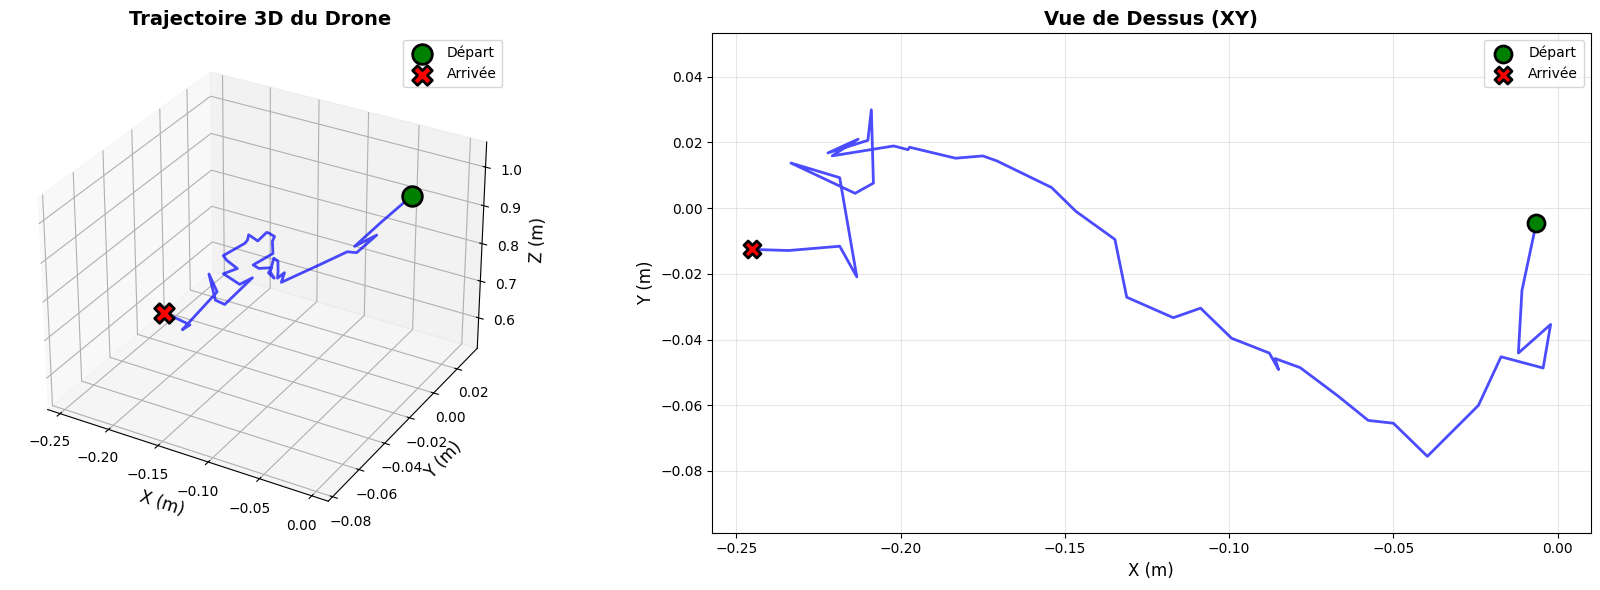

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# VISUALISATION TRAJECTOIRE
trajectory = slam.get_trajectory_array()

fig = plt.figure(figsize=(18, 6))

# Vue 3D
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 'b-', linewidth=2, alpha=0.7)
ax1.scatter(trajectory[0, 0], trajectory[0, 1], trajectory[0, 2],
           c='green', s=200, marker='o', label='Départ', edgecolors='black', linewidths=2)
ax1.scatter(trajectory[-1, 0], trajectory[-1, 1], trajectory[-1, 2],
           c='red', s=200, marker='X', label='Arrivée', edgecolors='black', linewidths=2)
ax1.set_xlabel('X (m)', fontsize=12)
ax1.set_ylabel('Y (m)', fontsize=12)
ax1.set_zlabel('Z (m)', fontsize=12)
ax1.set_title('Trajectoire 3D du Drone', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Vue de dessus (XY)
ax2 = fig.add_subplot(122)
ax2.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, alpha=0.7)
ax2.scatter(trajectory[0, 0], trajectory[0, 1], c='green', s=150, marker='o',
           label='Départ', edgecolors='black', linewidths=2, zorder=5)
ax2.scatter(trajectory[-1, 0], trajectory[-1, 1], c='red', s=150, marker='X',
           label='Arrivée', edgecolors='black', linewidths=2, zorder=5)
ax2.set_xlabel('X (m)', fontsize=12)
ax2.set_ylabel('Y (m)', fontsize=12)
ax2.set_title('Vue de Dessus (XY)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

plt.tight_layout()
plt.savefig('trajectoire_.png', dpi=200, bbox_inches='tight')
plt.show()

files.download('trajectoire_.png')

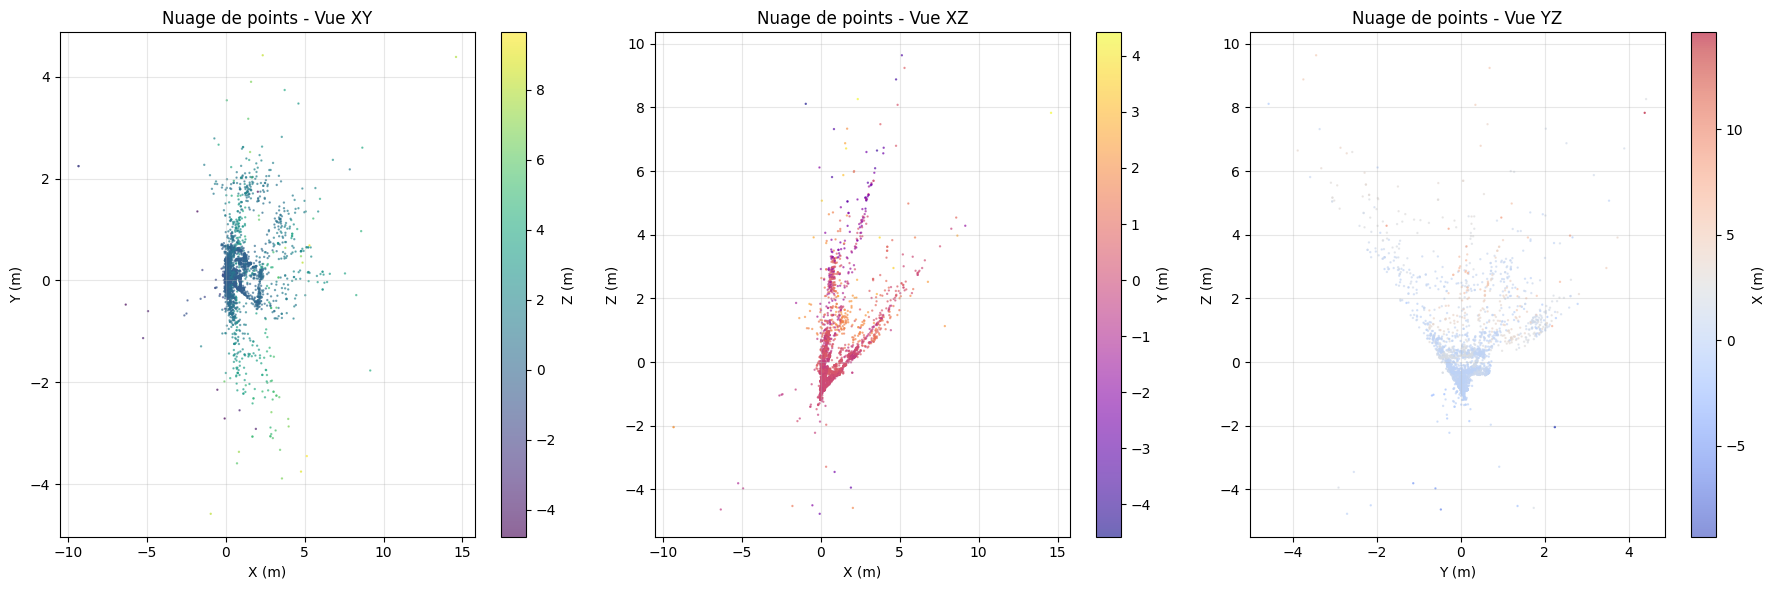

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# Visualisation 2D du nuage de points
if len(points) > 0:
    fig = plt.figure(figsize=(18, 6))

    # Vue XY
    ax1 = fig.add_subplot(131)
    scatter1 = ax1.scatter(points[:, 0], points[:, 1], c=points[:, 2], cmap='viridis', s=0.5, alpha=0.6)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_title('Nuage de points - Vue XY')
    plt.colorbar(scatter1, ax=ax1, label='Z (m)')
    ax1.grid(True, alpha=0.3)

    # Vue XZ
    ax2 = fig.add_subplot(132)
    scatter2 = ax2.scatter(points[:, 0], points[:, 2], c=points[:, 1], cmap='plasma', s=0.5, alpha=0.6)
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Z (m)')
    ax2.set_title('Nuage de points - Vue XZ')
    plt.colorbar(scatter2, ax=ax2, label='Y (m)')
    ax2.grid(True, alpha=0.3)

    # Vue YZ
    ax3 = fig.add_subplot(133)
    scatter3 = ax3.scatter(points[:, 1], points[:, 2], c=points[:, 0], cmap='coolwarm', s=0.5, alpha=0.6)
    ax3.set_xlabel('Y (m)')
    ax3.set_ylabel('Z (m)')
    ax3.set_title('Nuage de points - Vue YZ')
    plt.colorbar(scatter3, ax=ax3, label='X (m)')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('point_cloud_2d.png', dpi=150, bbox_inches='tight')
    plt.show()

    files.download('point_cloud_2d.png')

#### Trajectoire 2

In [4]:
print("Sélectionnez votre vidéo :")
uploaded = files.upload()
video_filename2 = list(uploaded.keys())[0]
print(f" Vidéo chargée : {video_filename2}")

Sélectionnez votre vidéo :


Saving vid1.mp4 to vid1.mp4
 Vidéo chargée : vid1.mp4


In [ ]:
# NOUVEAUX PARAMÈTRES DE CORRECTION
SCALE_FACTOR = 0.02  # Facteur d'échelle
MAX_TRANSLATION = 0.5  # Translation max entre 2 frames (en mètres)
MAX_ROTATION = 0.4  # Rotation max entre 2 frames (en radians)
MIN_ALTITUDE = 0.3  # Altitude minimum (sol)
MAX_ALTITUDE = 3.0  # Altitude maximum

In [ ]:
# TRAITEMENT DE LA VIDÉO
print("Démarrage du traitement...\n")

# slam = VisualSLAM(K, scale_factor=SCALE_FACTOR)
slam2 = SLAMWithBundleAdjustment(K, scale_factor=SCALE_FACTOR)
cap2 = cv2.VideoCapture(video_filename2)

if not cap2.isOpened():
    print("Erreur: impossible d'ouvrir la vidéo")
else:
    total_frames = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap2.get(cv2.CAP_PROP_FPS)
    print(f"Vidéo: {total_frames} frames, {fps:.1f} FPS\n")

    frame_count = 0
    skip_frames = 15  # Traiter toutes les frames pour plus de précision

    while True:
        ret, frame = cap2.read()
        if not ret:
            break

        frame_count += 1

        if frame_count % skip_frames != 0:
            continue

        slam2.process_frame(frame)

        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            current_pos = slam2.trajectory[-1][1].flatten()
            print(f" {progress:.1f}% | Poses: {len(slam2.trajectory)} | "
                  f"Points: {len(slam2.point_cloud)} | "
                  f"Position: [{current_pos[0]:.2f}, {current_pos[1]:.2f}, {current_pos[2]:.2f}]m | "
                  f"Rejetés: {slam2.rejected_frames}")

    # Bundle Adjustment final
    slam2.global_bundle_adjustment()
    cap2.release()
    print(f"\n Traitement terminé")
    print(f"   - Total poses: {len(slam.trajectory)}")
    print(f"   - Total points 3D: {len(slam.point_cloud)}")
    print(f"   - Frames rejetées: {slam.rejected_frames}")

In [ ]:
# VISUALISATION TRAJECTOIRE
trajectory2 = slam2.get_trajectory_array()

fig = plt.figure(figsize=(18, 6))

# Vue 3D
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(trajectory2[:, 0], trajectory2[:, 1], trajectory2[:, 2], 'b-', linewidth=2, alpha=0.7)
ax1.scatter(trajectory2[0, 0], trajectory2[0, 1], trajectory2[0, 2],
           c='green', s=200, marker='o', label='Départ', edgecolors='black', linewidths=2)
ax1.scatter(trajectory2[-1, 0], trajectory2[-1, 1], trajectory2[-1, 2],
           c='red', s=200, marker='X', label='Arrivée', edgecolors='black', linewidths=2)
ax1.set_xlabel('X (m)', fontsize=12)
ax1.set_ylabel('Y (m)', fontsize=12)
ax1.set_zlabel('Z (m)', fontsize=12)
ax1.set_title('Trajectoire 3D du Drone', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Vue de dessus (XY)
ax2 = fig.add_subplot(122)
ax2.plot(trajectory2[:, 0], trajectory2[:, 1], 'b-', linewidth=2, alpha=0.7)
ax2.scatter(trajectory2[0, 0], trajectory2[0, 1], c='green', s=150, marker='o',
           label='Départ', edgecolors='black', linewidths=2, zorder=5)
ax2.scatter(trajectory2[-1, 0], trajectory2[-1, 1], c='red', s=150, marker='X',
           label='Arrivée', edgecolors='black', linewidths=2, zorder=5)
ax2.set_xlabel('X (m)', fontsize=12)
ax2.set_ylabel('Y (m)', fontsize=12)
ax2.set_title('Vue de Dessus (XY)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

In [ ]:
fig = visualize_trajectory_plotly(slam2.trajectory)

In [ ]:
# 2. Avec nuage de points
points2, colors2 = slam2.get_point_cloud()
fig = visualize_trajectory_plotly(slam2.trajectory, points2, colors2)